# Direct Heston Calibration 

**day count convention**: actual / 365 - calculates the daily interest using a 365 day year and then multiplies that by actual number of days in each time period. Important for calculating the _accrued interest_.
https://www.youtube.com/watch?v=KuRoN6ZnA7o

**accrued interest**: refers to the amount of interest that has been incurred, as of a specific date, on a loan or other financial obligation but has not yet been paid out.

**calendar**: holidays / business days

**term structure**: Term structure of interest rates, commonly known as the yield curve, depicts the interest rates of similar quality bonds at different maturities.

**HestonModelHelper**: https://rkapl123.github.io/QLAnnotatedSource/dd/dc4/class_quant_lib_1_1_heston_model_helper.html#ab1df92f492a78501874b8580fdbeb697

**Pricing engines**: https://quantlib-python-docs.readthedocs.io/en/latest/pricing_engines.html
**AnalyticHestonEngine**:https://rkapl123.github.io/QLAnnotatedSource/d7/d80/class_quant_lib_1_1_analytic_heston_engine.html#details

**HestonModel Class Reference:**
https://rkapl123.github.io/QLAnnotatedSource/d6/d68/class_quant_lib_1_1_heston_model.html. 

**HestonProcess:**

 \begin{array}{rcl} dS(t, S) &=& \mu S dt + \sqrt{v} S dW_1 \\ dv(t, S) &=& \kappa (\theta - v) dt + \sigma \sqrt{v} dW_2 \\ dW_1 dW_2 &=& \rho dt \end{array} 


'Solvers such as Levenberg-Marquardt find local minimas and are very sensitive to the initial conditions. Depending on the starting conditions for your solver, you could end up with a good set of parameters with good convergence or not so good set of parameters.'

### LOCAL SOLVERS

**QLLM**: QuantLib Levenberg-Marquardt Solver https://rkapl123.github.io/QLAnnotatedSource/dd/d57/class_quant_lib_1_1_levenberg_marquardt.html

**SciLM**: Scipy Levenberg-Marquardt Solver
https://docs.scipy.org/doc/scipy/reference/optimize.root-lm.html

**LS**: Least Squares Method
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

### GLOBAL SOLVERS

**DE**: Differential Evolution
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

**BHA**: Basin Hopping Algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html

In [1]:
import QuantLib as ql
from math import pow, sqrt , log
import numpy as np
from scipy.optimize import root, least_squares, differential_evolution, basinhopping
from matplotlib import pyplot as plt,cm
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge,Lasso

In [2]:
day_count = ql.Actual365Fixed()   #day count convention
calendar = ql.UnitedStates()
calculation_date = ql.Date(6, 11, 2015)

spot = 659.37  #S_0
ql.Settings.instance().evaluationDate = calculation_date          

risk_free_rate = 0.01
dividend_rate = 0.0

##Creating term structures##
yield_ts = ql.YieldTermStructureHandle(                            #Flat interest-rate curve
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

'Following is a sample grid of volatilities for different expiration and strikes.'

In [3]:
expiration_dates = [ql.Date(6,12,2015), ql.Date(6,1,2016), ql.Date(6,2,2016),   #maturities from 1 month to 2 years
                    ql.Date(6,3,2016), ql.Date(6,4,2016), ql.Date(6,5,2016), 
                    ql.Date(6,6,2016), ql.Date(6,7,2016), ql.Date(6,8,2016),
                    ql.Date(6,9,2016), ql.Date(6,10,2016), ql.Date(6,11,2016), 
                    ql.Date(6,12,2016), ql.Date(6,1,2017), ql.Date(6,2,2017),
                    ql.Date(6,3,2017), ql.Date(6,4,2017), ql.Date(6,5,2017), 
                    ql.Date(6,6,2017), ql.Date(6,7,2017), ql.Date(6,8,2017),
                    ql.Date(6,9,2017), ql.Date(6,10,2017), ql.Date(6,11,2017)]

ttm=[ql.Period(m-calculation_date, ql.Days) for m in expiration_dates]


strikes = [527.50, 560.46, 593.43, 626.40, 659.37, 692.34, 725.31, 758.28]
data = [
[0.37819, 0.34177, 0.30394, 0.27832, 0.26453, 0.25916, 0.25941, 0.26127],
[0.3445, 0.31769, 0.2933, 0.27614, 0.26575, 0.25729, 0.25228, 0.25202],
[0.37419, 0.35372, 0.33729, 0.32492, 0.31601, 0.30883, 0.30036, 0.29568],
[0.37498, 0.35847, 0.34475, 0.33399, 0.32715, 0.31943, 0.31098, 0.30506],
[0.35941, 0.34516, 0.33296, 0.32275, 0.31867, 0.30969, 0.30239, 0.29631],
[0.35521, 0.34242, 0.33154, 0.3219, 0.31948, 0.31096, 0.30424, 0.2984],
[0.35442, 0.34267, 0.33288, 0.32374, 0.32245, 0.31474, 0.30838, 0.30283],
[0.35384, 0.34286, 0.33386, 0.32507, 0.3246, 0.31745, 0.31135, 0.306],
[0.35338, 0.343, 0.33464, 0.32614, 0.3263, 0.31961, 0.31371, 0.30852],
[0.35301, 0.34312, 0.33526, 0.32698, 0.32766, 0.32132, 0.31558, 0.31052],
[0.35272, 0.34322, 0.33574, 0.32765, 0.32873, 0.32267, 0.31705, 0.31209],
[0.35246, 0.3433, 0.33617, 0.32822, 0.32965, 0.32383, 0.31831, 0.31344],
[0.35226, 0.34336, 0.33651, 0.32869, 0.3304, 0.32477, 0.31934, 0.31453],
[0.35207, 0.34342, 0.33681, 0.32911, 0.33106, 0.32561, 0.32025, 0.3155],
[0.35171, 0.34327, 0.33679, 0.32931, 0.3319, 0.32665, 0.32139, 0.31675],
[0.35128, 0.343, 0.33658, 0.32937, 0.33276, 0.32769, 0.32255, 0.31802],
[0.35086, 0.34274, 0.33637, 0.32943, 0.3336, 0.32872, 0.32368, 0.31927],
[0.35049, 0.34252, 0.33618, 0.32948, 0.33432, 0.32959, 0.32465, 0.32034],
[0.35016, 0.34231, 0.33602, 0.32953, 0.33498, 0.3304, 0.32554, 0.32132],
[0.34986, 0.34213, 0.33587, 0.32957, 0.33556, 0.3311, 0.32631, 0.32217],
[0.34959, 0.34196, 0.33573, 0.32961, 0.3361, 0.33176, 0.32704, 0.32296],
[0.34934, 0.34181, 0.33561, 0.32964, 0.33658, 0.33235, 0.32769, 0.32368],
[0.34912, 0.34167, 0.3355, 0.32967, 0.33701, 0.33288, 0.32827, 0.32432],
[0.34891, 0.34154, 0.33539, 0.3297, 0.33742, 0.33337, 0.32881, 0.32492]]

In [4]:
class Heston(ql.HestonModel):
    def __init__(self, init_params=(0.02,0.2,0.5,0.1,0.01)):
        self.init_params=init_params
        v0, kappa, theta, sigma, rho = self.init_params
        process=ql.HestonProcess(yield_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
        super().__init__(process)
        self.engine = ql.AnalyticHestonEngine(self)
        self.vol_surf = ql.HestonBlackVolSurface(ql.HestonModelHandle(self), self.engine.Gatheral)
        
        self.build_helpers()
        
        
    def build_helpers(self, mat=ttm, K=strikes, vol=data):
        temp=[]
        for m,v in zip(mat,vol):
            for i,s in enumerate(K):
                temp.append( ql.HestonModelHelper(m, calendar, spot, s, ql.QuoteHandle(ql.SimpleQuote(v[i])), 
                                                  yield_ts, dividend_ts)  )
        for x in temp: x.setPricingEngine(self.engine)
        self.helpers=temp
        self.loss= [x.calibrationError() for x in self.helpers]
    
    def f_cost(self, params, norm=False):
        self.setParams( ql.Array(list(params)) )
        self.build_helpers()
        if norm == True:
            self.loss = np.sqrt(np.sum(self.loss))
        return self.loss
    
h = Heston()

In [5]:
class methods:
    def qllm(self):    
        self.calibrate(self.helpers,ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8),ql.EndCriteria(500, 300, 1.0e-8,1.0e-8, 1.0e-8))
    def scilm(self):    
        root(self.f_cost, self.init_params, method='lm')
    def ls(self):
        least_squares(self.f_cost, self.init_params)
    def de(self):
        bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]
        differential_evolution(self.f_cost, bounds, args=(True,), maxiter=100)
    def bha(self):
        bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]
        minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds, "args":(True,) }
        basinhopping(self.f_cost ,self.init_params, niter=5, minimizer_kwargs=minimizer_kwargs, 
                            stepsize=0.005, interval=10)
    
method_dict = { 'QLLM': methods.qllm ,'SciLM': methods.scilm,'LS': methods.ls, 'DE': methods.de, 'BHA': methods.bha} 

In [6]:
##calibrate model parameters with each method and calculate its error##
summary=[]
for i in method_dict:
    %time method_dict[i](h)
    h.build_helpers()
    summary.append([i, sum(h.loss)*100/len(h.loss)] + list(h.params()))
    
##Create table##
DataFrame(
    summary, columns=["Name", "Avg Rel Error (%)","$\theta$", "$\kappa$", "$\sigma$", "$\rho$", "$v_0$"],
    index=['']*len(summary)     )

CPU times: user 2.02 s, sys: 15.5 ms, total: 2.03 s
Wall time: 2.04 s
CPU times: user 2.13 s, sys: 12.7 ms, total: 2.14 s
Wall time: 2.16 s
CPU times: user 13.8 s, sys: 136 ms, total: 14 s
Wall time: 3.66 s
CPU times: user 1min 7s, sys: 163 ms, total: 1min 8s
Wall time: 1min 8s
CPU times: user 1min 5s, sys: 300 ms, total: 1min 6s
Wall time: 1min 6s


,Name,Avg Rel Error (%),$\theta$,$\kappa$,$\sigma$,$\rho$,$v_0$
,QLLM,3.015253,0.125747,7.915819,1.887957,-0.364943,0.055394
,SciLM,3.015250,0.125747,7.916034,1.887986,-0.364943,0.055393
,LS,3.015265,0.125748,7.915186,1.887876,-0.364942,0.055396
,DE,2.852929,0.123732,5.019711,0.997484,-0.551899,0.078480
,BHA,2.871932,0.123219,4.635233,0.831513,-0.630329,0.079447


# PLOTS

In [7]:
method_dict['QLLM'](h)
X, Y = np.meshgrid(strikes, [ql.Period(m-calculation_date, ql.Days).length() for m in expiration_dates])
Z=np.array([h.vol_surf.blackVol(m,s) 
            for m,s in zip(Y.reshape(1,-1)[0]/365, X.reshape(1,-1)[0])]).reshape(len(X),len(X[0]))


X_fine,Y_fine = np.meshgrid(np.arange(535., 750., 1),np.arange(0.1, 2, 0.1))
Z_fine=np.array([h.vol_surf.blackVol(m,s) 
            for m,s in zip(Y_fine.reshape(1,-1)[0], X_fine.reshape(1,-1)[0])]).reshape(len(X_fine),len(X_fine[0]))


implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]
black_var_surface = ql.BlackVarianceSurface(calculation_date, calendar, expiration_dates,
                                                strikes, implied_vols, day_count)
Z_black=np.array([black_var_surface.blackVol(m,s) 
            for m,s in zip(Y_fine.reshape(1,-1)[0], X_fine.reshape(1,-1)[0])]).reshape(len(X_fine),len(X_fine[0]))



<IPython.core.display.Javascript object>


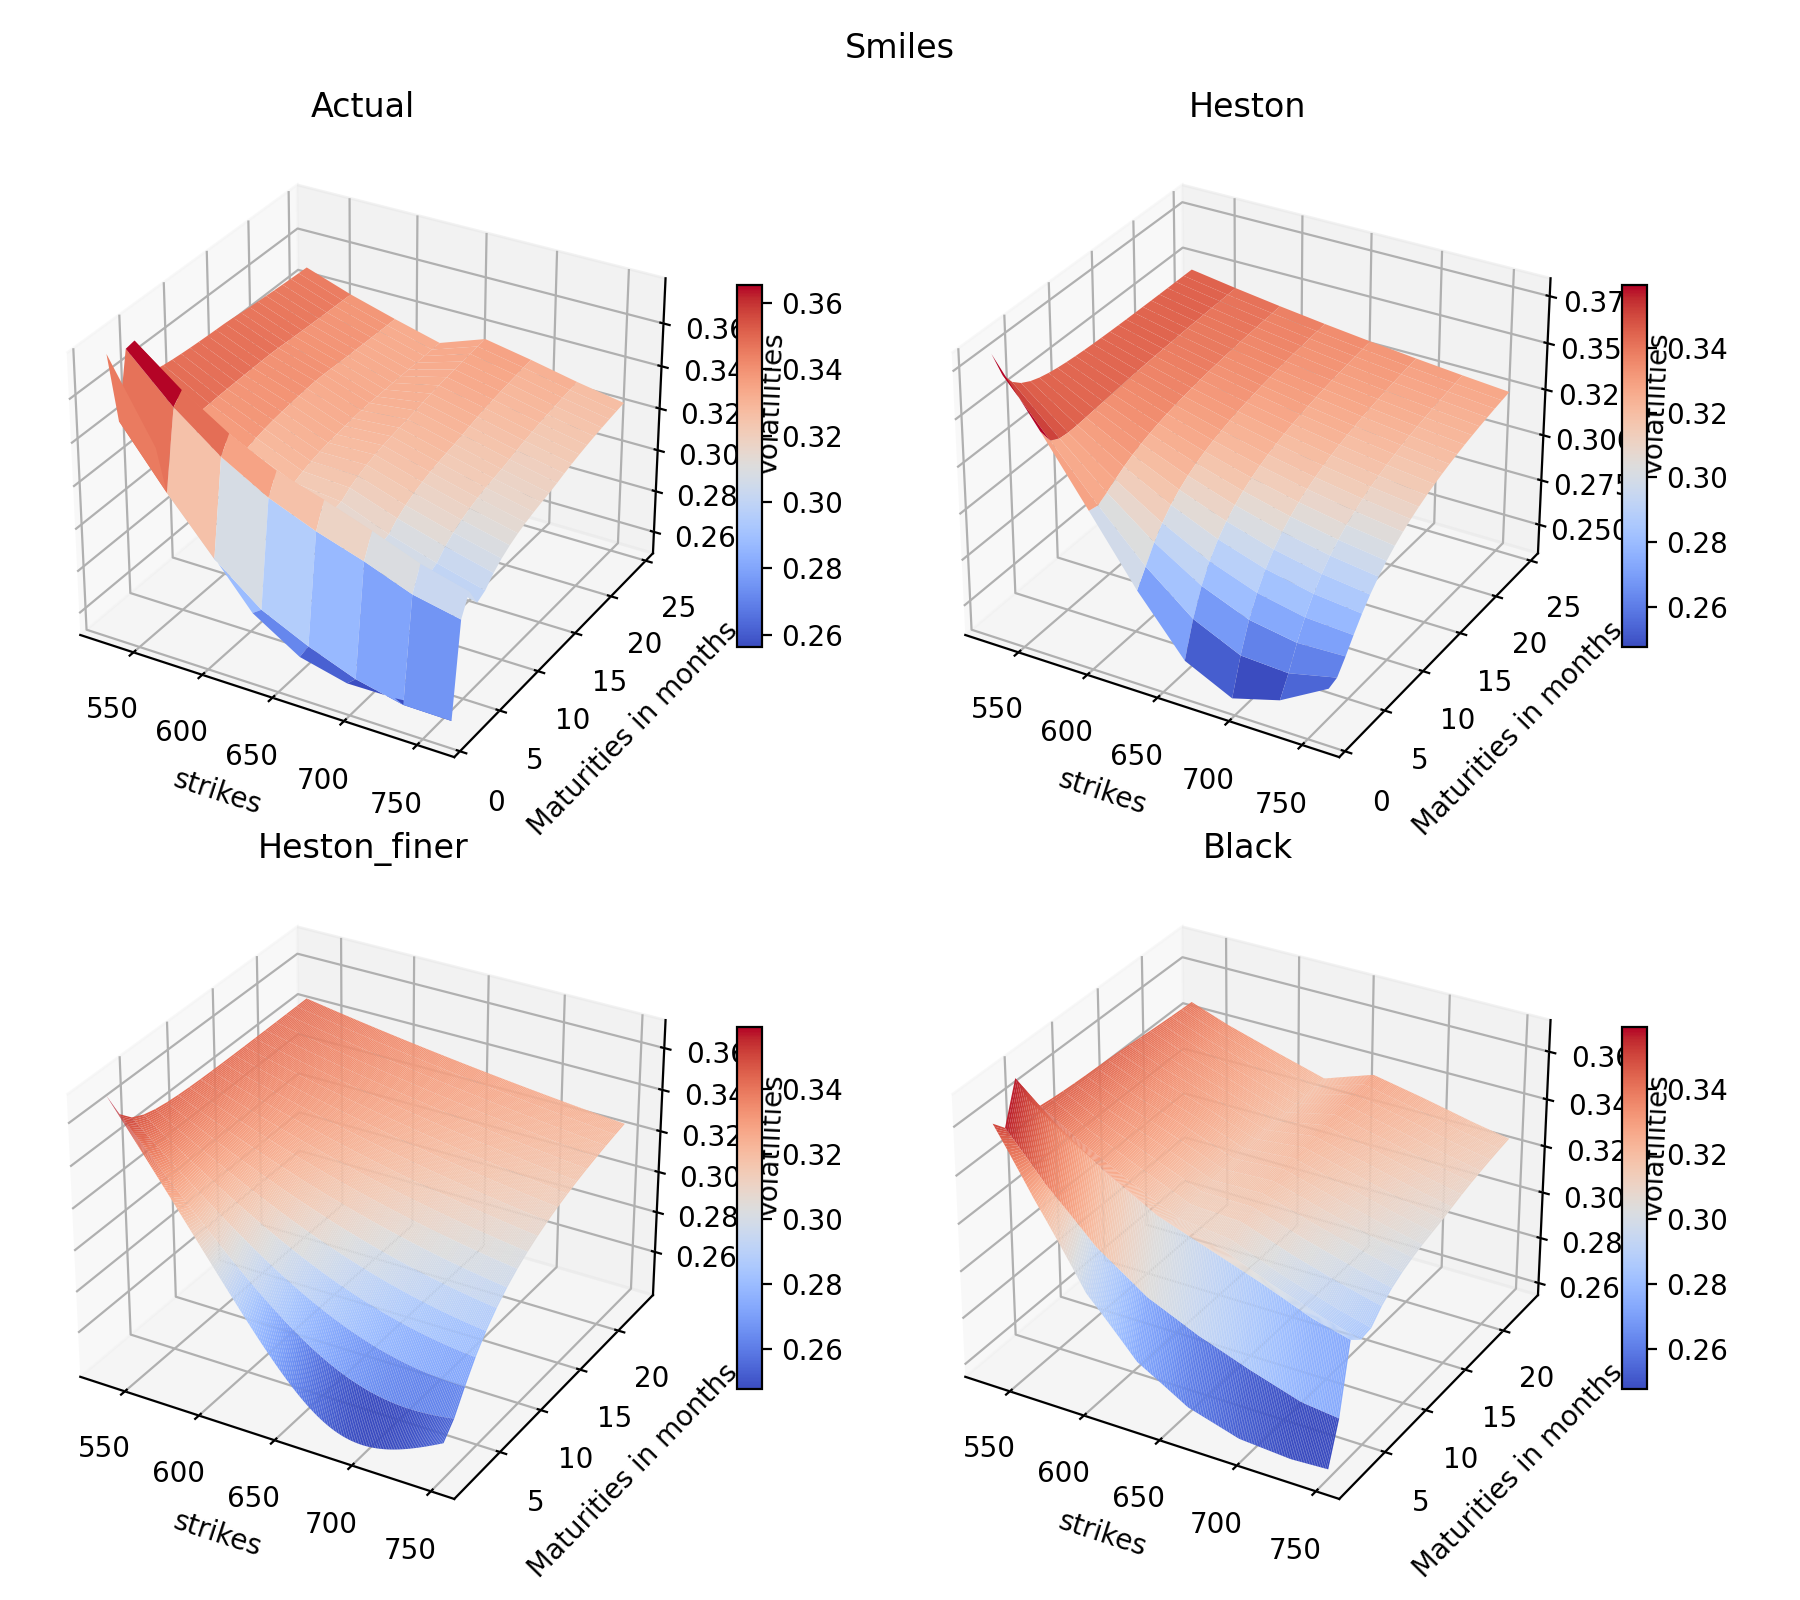

In [8]:
%matplotlib notebook
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(9)

ax1 = fig.add_subplot(2, 2, 1, projection='3d',xlabel='strikes',ylabel='Maturities in months', zlabel='volatilities',title='Actual')
surf1=ax1.plot_surface(X, Y/30, np.array(data), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf1, shrink=0.5, aspect=15)

ax2 = fig.add_subplot(2, 2, 2, projection='3d',xlabel='strikes',ylabel='Maturities in months', zlabel='volatilities',title='Heston')
surf2 = ax2.plot_surface(X, Y/30, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf2, shrink=0.5, aspect=15)

ax3 = fig.add_subplot(2,2,3, projection='3d',xlabel='strikes',ylabel='Maturities in months', zlabel='volatilities',title='Heston_finer')
surf3 = ax3.plot_surface(X_fine, Y_fine*365/30, Z_fine, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf2, shrink=0.5, aspect=15)

ax4 = fig.add_subplot(2,2,4, projection='3d',xlabel='strikes',ylabel='Maturities in months', zlabel='volatilities',title='Black')
surf4 = ax4.plot_surface(X_fine, Y_fine*365/30, Z_black, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
fig.colorbar(surf2, shrink=0.5, aspect=15)

fig.suptitle('Smiles')
plt.tight_layout()
